### Imports

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import librosa         
import librosa.display
from IPython.display import Audio
import IPython.display
from scipy.fftpack import fft
import scipy
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
%matplotlib inline
from sklearn.metrics import f1_score

# 1. Download the Dataset and Understand the Format

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
google_drive = GoogleDrive(gauth)
downloaded = google_drive.CreateFile({'id':"1v4zSFOdfbFyMFalPVB95M0atJDryKRYb"})
downloaded.GetContentFile('Crema.zip')        
!unzip -qq /content/Crema.zip -d /content/dataset

In [ ]:
path = "/content/dataset/Crema/"
crema_directory = os.listdir(path)

In [ ]:
emotions = []
file_path = []

In [ ]:
for file in crema_directory:
  file_path.append(path + file)
  emotion = file.split('_')
  if emotion[2] == 'SAD':
      emotions.append('sad')
  elif emotion[2] == 'ANG':
      emotions.append('angry')
  elif emotion[2] == 'DIS':
      emotions.append('disgust')
  elif emotion[2] == 'FEA':
      emotions.append('fear')
  elif emotion[2] == 'HAP':
      emotions.append('happy')
  elif emotion[2] == 'NEU':
      emotions.append('neutral')
  else:
      emotions.append('unknown emotion')

In [ ]:
Emotions_df = pd.DataFrame(emotions, columns=['Emotion'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([path_df, Emotions_df], axis=1)
Crema_df.head()

,Path,Emotion
0,/content/dataset/Crema/1082_IWL_FEA_XX.wav,fear
1,/content/dataset/Crema/1062_TSI_HAP_XX.wav,happy
2,/content/dataset/Crema/1013_IEO_FEA_MD.wav,fear
3,/content/dataset/Crema/1034_DFA_NEU_XX.wav,neutral
4,/content/dataset/Crema/1012_ITH_NEU_XX.wav,neutral


In [ ]:
Crema_df.shape

(7442, 2)

In [ ]:
Crema_df.dtypes

Path       object
Emotion    object
dtype: object

In [ ]:
Crema_df['Emotion'].value_counts()

fear       1271
happy      1271
sad        1271
angry      1271
disgust    1271
neutral    1087
Name: Emotion, dtype: int64

In [ ]:
Crema_df['Emotion'].replace(['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral'],
                        [0, 1, 2, 3, 4, 5], inplace=True)

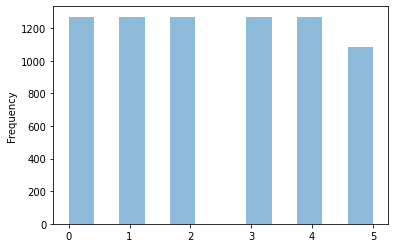

In [ ]:
Crema_df['Emotion'].plot.hist(bins=12, alpha=0.5)

In [ ]:
dic = {0 : 'sad',
        1 : 'angry',
        2 : 'disgust',
        3 : 'fear',
        4 : 'happy',
        5 : 'neutral'}

In [ ]:
def plot_waveform(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 5))
    plt.title('Waveplot for {} emotion'.format(dic[emotion].upper()), size=15)
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.show()
def spectrogram(data, sampling_rate, emotion):
    X = librosa.stft(data)                      # stft function converts the data into short term fourier transform, we're working in frequency domain
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 5))
    plt.title('Spectrogram for  {} emotion'.format(dic[emotion].upper()), size=15)
    p=librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')   
    plt.colorbar()
    return p
def load_audio(path):
  data, sampling_rate = librosa.load(path)
  plot_waveform(data, sampling_rate, emotion)
  p=spectrogram(data, sampling_rate, emotion)
  print(f'Sampling rate: {sampling_rate}')
  IPython.display.display(Audio(path))
  return p   

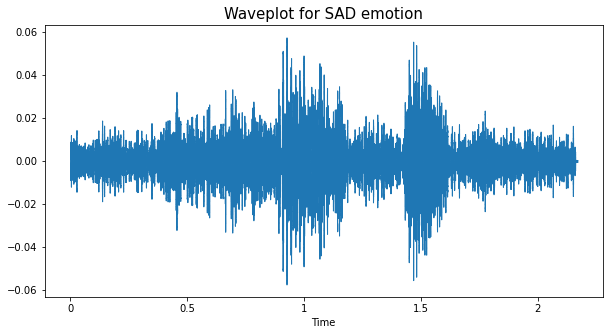

Sampling rate: 22050


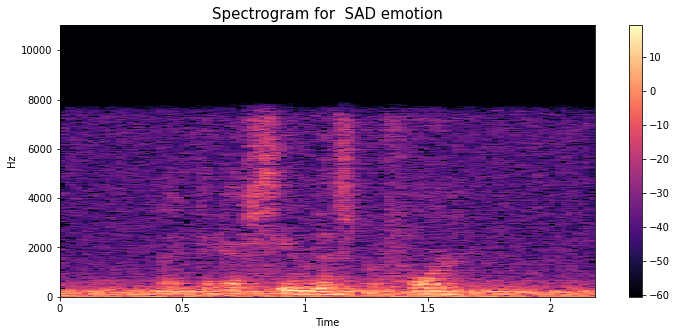

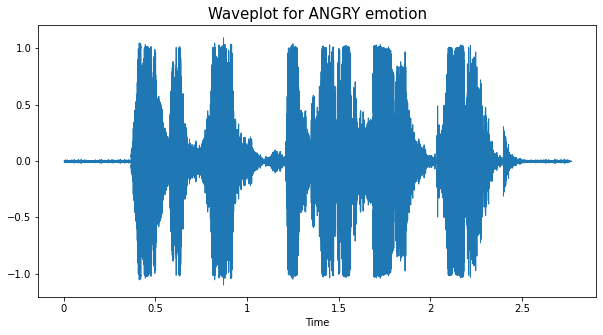

Sampling rate: 22050


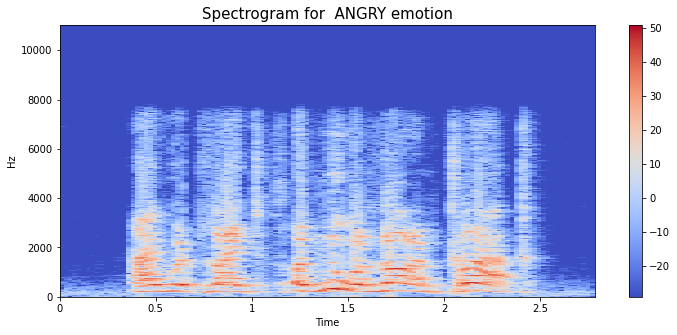

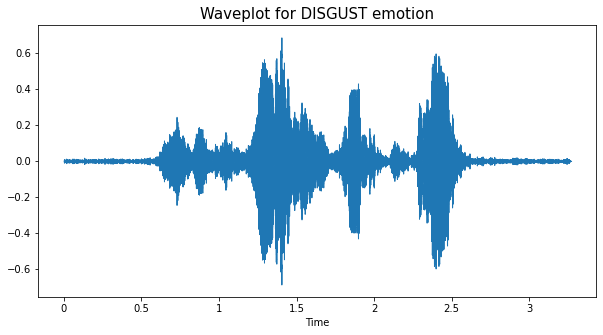

Sampling rate: 22050


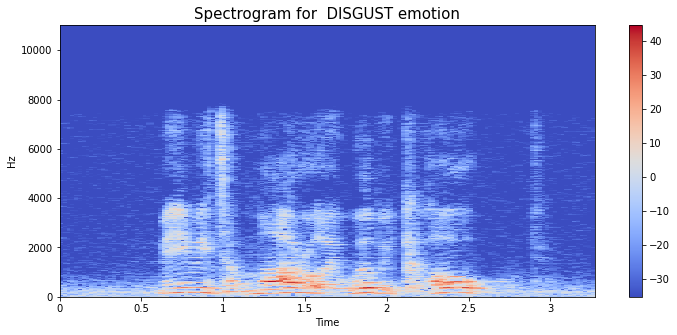

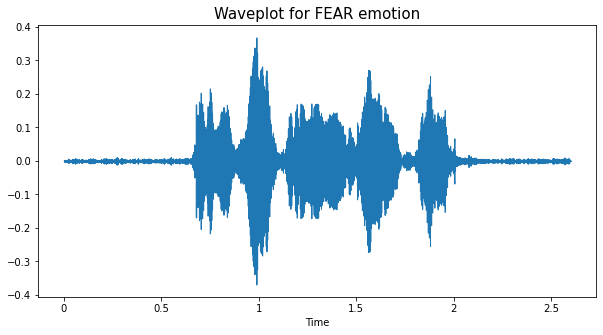

Sampling rate: 22050


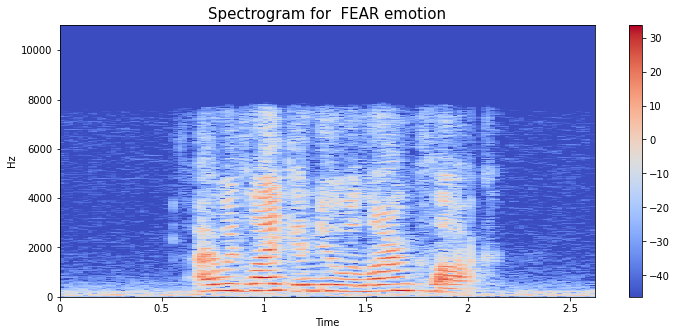

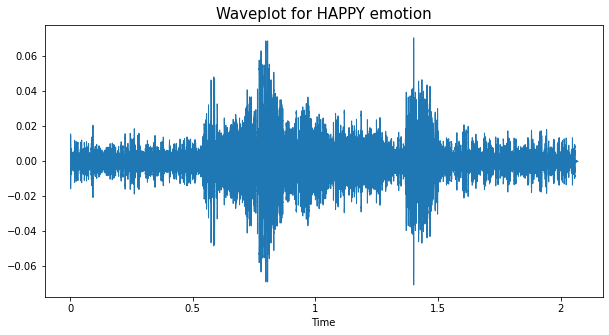

Sampling rate: 22050


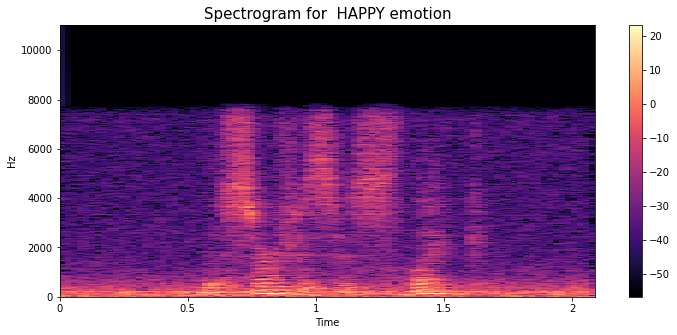

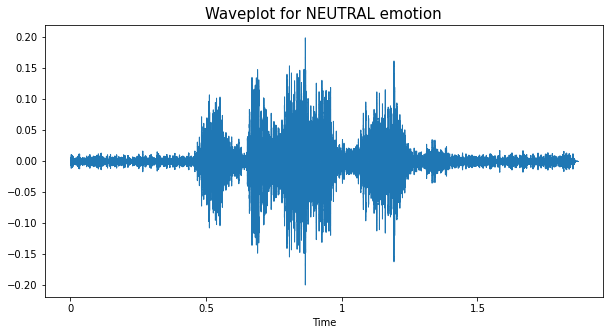

Sampling rate: 22050


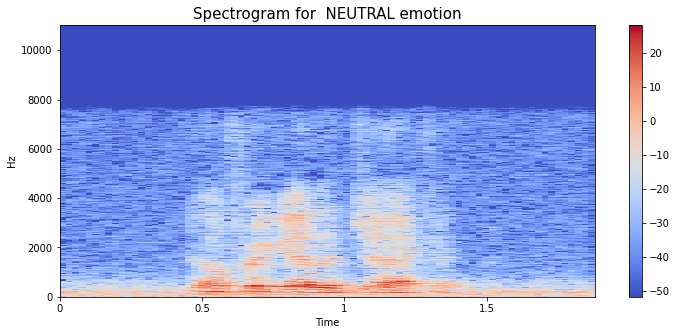

In [ ]:

emotions = [0, 1, 2, 3, 4, 5]
for emotion in emotions:
  path = np.array(Crema_df.Path[Crema_df.Emotion==emotion])[0]
  p=load_audio(path)
  print(p)

In [ ]:
train_val_df, test_df = train_test_split(Crema_df, test_size=0.3, random_state=32)

In [ ]:
train_df, val_df = train_test_split(train_val_df, test_size=0.05, random_state=32)

In [ ]:
train_df['Emotion'].value_counts()

4    861
0    848
1    847
3    845
2    809
5    738
Name: Emotion, dtype: int64

# 2. Create the Feature Space

#### A - work on time domain or frequency domain

In [ ]:
params = {'batch_size': 32,
          'num_workers': 2}


In [ ]:
class TimeDomainDataset(torch.utils.data.Dataset):
  def __init__(self, df):
        self.df = df

  def __len__(self):
        return len(self.df)

  def __getitem__(self, index):
        max_shape = (1, 314)
        row = self.df.iloc[index]
        sample, sr = librosa.load(row['Path'], sr=None)
        X_zcr = librosa.feature.zero_crossing_rate(sample)
        X_rms = librosa.feature.rms(sample)

        X = np.concatenate((X_zcr, X_rms), axis=None)
        X = np.expand_dims(X, axis=0)
        padded_array = np.zeros(max_shape)
        shape = np.shape(X)
        padded_array[:shape[0],:shape[1]] = X
        X = padded_array
        
        y = row['Emotion']
        return X, y

In [ ]:
training_1D_set = TimeDomainDataset(train_df)
testing_1D_set = TimeDomainDataset(test_df)
validating_1D_set = TimeDomainDataset(val_df)

In [ ]:
training_generator_1D = torch.utils.data.DataLoader(training_1D_set, **params)
testing_generator_1D = torch.utils.data.DataLoader(testing_1D_set, **params)
validating_generator_1D = torch.utils.data.DataLoader(validating_1D_set, **params)

In [ ]:
for x, y in training_generator_1D:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 1, 314])
torch.Size([32])


#### B - Convert the audio waveform to mel spectrogram

In [ ]:
class SpectrogramDataset(torch.utils.data.Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    max_shape = (128, 157)
    row = self.df.iloc[index]
    sample, sr = librosa.load(row['Path'], sr=None)
    X = librosa.feature.melspectrogram(sample, sr=sr)
    padded_array = np.zeros(max_shape)
    shape = np.shape(X)
    padded_array[:shape[0],:shape[1]] = X
    X = padded_array
    X = torch.from_numpy(np.expand_dims(X, axis=0)).float()
    y = row['Emotion']
    return X, y

In [ ]:
training_2D_set = SpectrogramDataset(train_df)
testing_2D_set = SpectrogramDataset(test_df)
validating_2D_set = SpectrogramDataset(val_df)

In [ ]:
training_generator_2D = torch.utils.data.DataLoader(training_2D_set, **params)
testing_generator_2D = torch.utils.data.DataLoader(testing_2D_set, **params)
validating_generator_2D = torch.utils.data.DataLoader(validating_2D_set, **params)

In [ ]:
for x, y in training_generator_2D:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 1, 128, 157])
torch.Size([32])


# 3. Building the Model

In [ ]:
def train_fn(model, data_loader, optimizer, loss_fn):
  total_loss = 0
  total_acc = 0
  model.train()

  for data in tqdm(data_loader):
    sound, label = data
    sound, label = sound.to(DEVICE), label.to(DEVICE)
    model.train()
    optimizer.zero_grad()
    y_pred = model(sound.float())
    loss = loss_fn(y_pred, label)
    loss.backward()
    optimizer.step()

    _, y_pred = torch.max(y_pred, dim = 1) 
    correct_pred = (label == y_pred).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    
    total_acc += acc
    total_loss += loss

  return total_loss / len(data_loader), total_acc / len(data_loader)

In [ ]:
def eval_fn(model, data_loader, loss_fn):
  total_loss = 0
  total_acc = 0
  model.eval()
  with torch.no_grad():
    for data in tqdm(data_loader):
      sound, label = data
      sound, label = sound.to(DEVICE), label.to(DEVICE)
      y_pred = model(sound.float())
      loss = loss_fn(y_pred, label)

      _, y_pred = torch.max(y_pred, dim = 1) 
      correct_pred = (label == y_pred).float()
      acc = correct_pred.sum() / len(correct_pred)
      acc = torch.round(acc * 100)
      
      total_acc += acc
      total_loss += loss

  return total_loss / len(data_loader), total_acc / len(data_loader)

In [ ]:
def run_model(model, optimizer, criterion, train, val, patience):
  best_loss = np.inf
  last_loss = 0
  trigger_times = 0
  for i in range(EPOCHS):
    train_loss, train_acc = train_fn(model, train, optimizer, criterion)
    val_loss, val_acc = eval_fn(model, val, criterion)
    print(f'EPOCH : {i+1} - Train acc : {train_acc} - Train loss : {train_loss}')
    print(f'EPOCH : {i+1} - Val acc : {val_acc} - Val loss : {val_loss}')

  # Early stopping
    if val_loss > last_loss:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!\nStart to test process.')
            return model
    else:
        trigger_times = 0

    last_loss = val_loss

    if val_loss < best_loss:
      torch.save(model.state_dict(), 'best_model.pt')
      print('WEIGHT_ARE_SAVED')
      best_loss = val_loss
  return model

In [ ]:
class CNNBlock1D(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(CNNBlock1D, self).__init__()
    self.cnn1d = nn.Conv1d(in_channel, out_channel, kernel_size=5, stride=1)
    self.max_p_1d = nn.MaxPool1d(kernel_size=5, stride=2)

  def forward(self, data):
    x = self.cnn1d(data)
    x = F.relu(x)
    x = self.max_p_1d(x)
    return x

In [ ]:
class Model1D(nn.Module):

  def _init_(self):
    super(Model1D, self)._init_()
    self.b1 = CNNBlock1D(1, 512)
    self.b2 = CNNBlock1D(512, 512)
    self.b3 = CNNBlock1D(512, 128)
    self.fc1 = nn.Linear(4224, 256)
    self.fc2 = nn.Linear(256, 6)
    self.fl = nn.Flatten()
    self.dropout = nn.Dropout(0.5)
    
  def forward(self, data):
    x = self.b1(data)
    x = self.dropout(x)
    x = self.b2(x)
    x = self.dropout(x)
    x = self.b3(x)
    x = self.fl(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = F.log_softmax(x, -1)
    return x


In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
LR = 1e-3

In [ ]:
DEVICE

device(type='cuda', index=0)

In [ ]:
model = Model1D()
model = model.to(DEVICE)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()
m1_1d = run_model(model, optimizer, criterion, training_generator_1D, validating_generator_1D, 5)

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 1 - Train acc : 25.783918380737305 - Train loss : 1.6949998140335083
EPOCH : 1 - Val acc : 37.043479919433594 - Val loss : 1.5884172916412354
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 2 - Train acc : 33.100502014160156 - Train loss : 1.588966727256775
EPOCH : 2 - Val acc : 38.08695602416992 - Val loss : 1.536203384399414
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 3 - Train acc : 35.22110366821289 - Train loss : 1.5554014444351196
EPOCH : 3 - Val acc : 41.173912048339844 - Val loss : 1.5014032125473022
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 4 - Train acc : 37.3668327331543 - Train loss : 1.5236331224441528
EPOCH : 4 - Val acc : 42.56521987915039 - Val loss : 1.4435230493545532
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 5 - Train acc : 39.01507568359375 - Train loss : 1.5013408660888672
EPOCH : 5 - Val acc : 45.69565200805664 - Val loss : 1.4244883060455322
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 6 - Train acc : 40.52763748168945 - Train loss : 1.478065848350525
EPOCH : 6 - Val acc : 44.30434799194336 - Val loss : 1.4304195642471313


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 7 - Train acc : 40.97990036010742 - Train loss : 1.4573158025741577
EPOCH : 7 - Val acc : 46.56521987915039 - Val loss : 1.394985556602478
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 8 - Train acc : 41.20602798461914 - Train loss : 1.453086495399475
EPOCH : 8 - Val acc : 46.91304397583008 - Val loss : 1.3865019083023071
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 9 - Train acc : 41.47236251831055 - Train loss : 1.4497706890106201
EPOCH : 9 - Val acc : 47.34782791137695 - Val loss : 1.3844319581985474
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 10 - Train acc : 41.53266143798828 - Train loss : 1.443487286567688
EPOCH : 10 - Val acc : 47.5217399597168 - Val loss : 1.3688465356826782
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 11 - Train acc : 42.36180877685547 - Train loss : 1.4324332475662231
EPOCH : 11 - Val acc : 46.65217590332031 - Val loss : 1.3715084791183472


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 12 - Train acc : 42.69346618652344 - Train loss : 1.4200396537780762
EPOCH : 12 - Val acc : 47.91304397583008 - Val loss : 1.3671621084213257
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 13 - Train acc : 43.211055755615234 - Train loss : 1.4191861152648926
EPOCH : 13 - Val acc : 47.30434799194336 - Val loss : 1.3800628185272217


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 14 - Train acc : 42.56281280517578 - Train loss : 1.420093059539795
EPOCH : 14 - Val acc : 47.21739196777344 - Val loss : 1.3727288246154785


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 15 - Train acc : 42.9095458984375 - Train loss : 1.412017822265625
EPOCH : 15 - Val acc : 46.826087951660156 - Val loss : 1.3735430240631104


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 16 - Train acc : 43.743717193603516 - Train loss : 1.4058586359024048
EPOCH : 16 - Val acc : 47.739131927490234 - Val loss : 1.360059142112732
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 17 - Train acc : 44.70854187011719 - Train loss : 1.3949707746505737
EPOCH : 17 - Val acc : 48.91304397583008 - Val loss : 1.3548089265823364
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 18 - Train acc : 43.849246978759766 - Train loss : 1.3961738348007202
EPOCH : 18 - Val acc : 49.0 - Val loss : 1.3588595390319824


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 19 - Train acc : 44.120601654052734 - Train loss : 1.3887842893600464
EPOCH : 19 - Val acc : 49.4782600402832 - Val loss : 1.3579081296920776


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 20 - Train acc : 44.492462158203125 - Train loss : 1.3872663974761963
EPOCH : 20 - Val acc : 49.4782600402832 - Val loss : 1.3555864095687866


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 21 - Train acc : 44.778892517089844 - Train loss : 1.3863348960876465
EPOCH : 21 - Val acc : 48.78260803222656 - Val loss : 1.3475871086120605
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 22 - Train acc : 44.5728645324707 - Train loss : 1.38322114944458
EPOCH : 22 - Val acc : 49.4782600402832 - Val loss : 1.3397096395492554
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 23 - Train acc : 45.211055755615234 - Train loss : 1.3663222789764404
EPOCH : 23 - Val acc : 50.0 - Val loss : 1.3394451141357422
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 24 - Train acc : 44.84421920776367 - Train loss : 1.379469871520996
EPOCH : 24 - Val acc : 49.95652389526367 - Val loss : 1.3487536907196045


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 25 - Train acc : 44.93467330932617 - Train loss : 1.3721270561218262
EPOCH : 25 - Val acc : 50.130435943603516 - Val loss : 1.339888334274292


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 26 - Train acc : 46.105525970458984 - Train loss : 1.3617751598358154
EPOCH : 26 - Val acc : 50.39130401611328 - Val loss : 1.3368793725967407
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 27 - Train acc : 46.055274963378906 - Train loss : 1.3594558238983154
EPOCH : 27 - Val acc : 50.826087951660156 - Val loss : 1.3461641073226929


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 28 - Train acc : 46.567840576171875 - Train loss : 1.355150818824768
EPOCH : 28 - Val acc : 51.08695602416992 - Val loss : 1.3298585414886475
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 29 - Train acc : 45.71859359741211 - Train loss : 1.3586612939834595
EPOCH : 29 - Val acc : 51.5217399597168 - Val loss : 1.3299914598464966


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 30 - Train acc : 45.93467330932617 - Train loss : 1.344915509223938
EPOCH : 30 - Val acc : 51.60869598388672 - Val loss : 1.3319308757781982


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 31 - Train acc : 46.15577697753906 - Train loss : 1.3435587882995605
EPOCH : 31 - Val acc : 51.69565200805664 - Val loss : 1.3324248790740967


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 32 - Train acc : 46.52763748168945 - Train loss : 1.3428328037261963
EPOCH : 32 - Val acc : 52.0 - Val loss : 1.331114649772644


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 33 - Train acc : 47.17085266113281 - Train loss : 1.3316737413406372
EPOCH : 33 - Val acc : 52.21739196777344 - Val loss : 1.3202944993972778
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 34 - Train acc : 46.4874382019043 - Train loss : 1.3399901390075684
EPOCH : 34 - Val acc : 50.39130401611328 - Val loss : 1.3257535696029663


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 35 - Train acc : 46.61306381225586 - Train loss : 1.332309603691101
EPOCH : 35 - Val acc : 50.826087951660156 - Val loss : 1.318687915802002
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 36 - Train acc : 47.145729064941406 - Train loss : 1.324082374572754
EPOCH : 36 - Val acc : 51.4782600402832 - Val loss : 1.335847020149231


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 37 - Train acc : 47.32663345336914 - Train loss : 1.3190981149673462
EPOCH : 37 - Val acc : 50.65217590332031 - Val loss : 1.3119014501571655
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 38 - Train acc : 47.51758575439453 - Train loss : 1.3210829496383667
EPOCH : 38 - Val acc : 51.69565200805664 - Val loss : 1.320995807647705


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 39 - Train acc : 47.52763748168945 - Train loss : 1.3109033107757568
EPOCH : 39 - Val acc : 50.91304397583008 - Val loss : 1.3185994625091553


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 40 - Train acc : 47.95477294921875 - Train loss : 1.3136636018753052
EPOCH : 40 - Val acc : 52.434783935546875 - Val loss : 1.3054778575897217
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 41 - Train acc : 47.61809158325195 - Train loss : 1.3146849870681763
EPOCH : 41 - Val acc : 52.130435943603516 - Val loss : 1.3037915229797363
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 42 - Train acc : 48.23617935180664 - Train loss : 1.2987046241760254
EPOCH : 42 - Val acc : 51.17391586303711 - Val loss : 1.3077892065048218


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 43 - Train acc : 48.51758575439453 - Train loss : 1.2936140298843384
EPOCH : 43 - Val acc : 52.043479919433594 - Val loss : 1.3120224475860596


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 44 - Train acc : 48.869346618652344 - Train loss : 1.2903385162353516
EPOCH : 44 - Val acc : 50.95652389526367 - Val loss : 1.3149704933166504


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 45 - Train acc : 48.89447021484375 - Train loss : 1.2939196825027466
EPOCH : 45 - Val acc : 52.130435943603516 - Val loss : 1.3003320693969727
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 46 - Train acc : 49.01507568359375 - Train loss : 1.2788292169570923
EPOCH : 46 - Val acc : 51.739131927490234 - Val loss : 1.2994847297668457
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 47 - Train acc : 48.84421920776367 - Train loss : 1.2838822603225708
EPOCH : 47 - Val acc : 50.4782600402832 - Val loss : 1.3089287281036377


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 48 - Train acc : 49.18592834472656 - Train loss : 1.2845216989517212
EPOCH : 48 - Val acc : 50.0 - Val loss : 1.3090888261795044


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 49 - Train acc : 48.53266143798828 - Train loss : 1.2833850383758545
EPOCH : 49 - Val acc : 50.65217590332031 - Val loss : 1.306667685508728


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 50 - Train acc : 49.81407165527344 - Train loss : 1.2724968194961548
EPOCH : 50 - Val acc : 52.0 - Val loss : 1.3079994916915894


In [ ]:
PATH = '/content/best_model.pt'

In [ ]:
m1_1d = Model1D()
m1_1d.load_state_dict(torch.load(PATH))
m1_1d = m1_1d.to(DEVICE)

In [ ]:
test_loss, test_acc = eval_fn(m1_1d, testing_generator_1D, criterion)
print(f'Test acc : {test_acc} - Test loss : {test_loss}')

  0%|          | 0/12 [00:00<?, ?it/s]

Test acc : 44.41666793823242 - Test loss : 1.410605788230896


In [ ]:
class CNNBlock2D(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(CNNBlock2D, self).__init__()
    self.cnn2d = nn.Conv2d(in_channel, out_channel, kernel_size=5, stride=1)  
    self.max_p_2d = nn.MaxPool2d(kernel_size=5, stride=2)

  def forward(self, data):
    x = self.cnn2d(data)
    x = F.relu(x)
    x = self.max_p_2d(x)
    return x

In [ ]:
class Model2D(nn.Module):

  def _init_(self):
    super(Model2D, self)._init_()
    self.b1 = CNNBlock2D(1, 512)
    self.b2 = CNNBlock2D(512, 512)
    self.b3 = CNNBlock2D(512, 128)
    self.fc1 = nn.Linear(14976, 256)
    self.fc2 = nn.Linear(256, 6)
    self.fl = nn.Flatten()
    self.dropout = nn.Dropout(0.5)

  def forward(self, data):
    x = self.b1(data)
    x = self.dropout(x)
    x = self.b2(x)
    x = self.dropout(x)
    x = self.b3(x)
    x = self.fl(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = F.log_softmax(x, -1)
    return x


In [ ]:
pip install torchensemble

     |████████████████████████████████| 40 kB 5.4 MB/s 


In [ ]:
EPOCHS = 5
LR = 1e-2

In [ ]:
from torchensemble import VotingClassifier
model_e = VotingClassifier(
    estimator=Model2D,
    n_estimators=5,
    cuda=True,
)

model_e.set_optimizer('Adam', lr=LR, weight_decay=5e-3) 
criterion = nn.CrossEntropyLoss()
model_e.set_criterion(criterion)
model_e.fit(train_loader=training_generator_2D, epochs=EPOCHS,  test_loader=validating_generator_2D)                 

Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 7.45672 | Correct: 3/32
Estimator: 000 | Epoch: 000 | Batch: 100 | Loss: 1.79841 | Correct: 6/32
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 6.30912 | Correct: 7/32
Estimator: 001 | Epoch: 000 | Batch: 100 | Loss: 1.80391 | Correct: 7/32
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 5.58760 | Correct: 10/32
Estimator: 002 | Epoch: 000 | Batch: 100 | Loss: 1.78488 | Correct: 6/32
Estimator: 003 | Epoch: 000 | Batch: 000 | Loss: 7.33289 | Correct: 2/32
Estimator: 003 | Epoch: 000 | Batch: 100 | Loss: 1.79574 | Correct: 6/32
Estimator: 004 | Epoch: 000 | Batch: 000 | Loss: 3.00552 | Correct: 10/32
Estimator: 004 | Epoch: 000 | Batch: 100 | Loss: 1.78677 | Correct: 7/32
Estimator: 000 | Epoch: 001 | Batch: 000 | Loss: 1.79179 | Correct: 4/32
Estimator: 000 | Epoch: 001 | Batch: 100 | Loss: 1.78728 | Correct: 8/32
Estimator: 001 | Epoch: 001 | Batch: 000 | Loss: 1.80543 | Correct: 3/32
Estimator: 001 | Epoch: 001 | Batch: 100 | Loss: 

In [ ]:
def eval(data):
  total_acc = 0
  for x,y in tqdm(data):
    x = x.to
    accuracy = model.predict(x)
    _, y_pred = torch.max(y_pred, dim = 1) 
    correct_pred = (y == y_pred).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    total_acc += acc
  #  return y_pred

  print(f"ACC : {total_acc / len(data)}")
      

In [ ]:
eval(testing_generator_2D)
eval(training_generator_2D)
eval(validating_generator_2D)

'eval(testing_generator_2D)\neval(training_generator_2D)\neval(validating_generator_2D)'

In [ ]:
#f1score = f1_score(y_test, y_pred_testing, average = 'weighted')
#print('F1 score for: %f' % f1score)

In [ ]:
model_2d = Model2D()
model_2d = model_2d.to(DEVICE)

In [ ]:
EPOCHS = 8
LR = 1e-2

In [ ]:
optimizer = torch.optim.Adam(model_2d.parameters(), lr = LR, weight_decay=5e-3) 
criterion = nn.CrossEntropyLoss()
m1_2d = run_model(model_2d, optimizer, criterion, training_generator_2D, validating_generator_2D, 5)

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 1 - Train acc : 17.115577697753906 - Train loss : 2633.388916015625
EPOCH : 1 - Val acc : 16.217391967773438 - Val loss : 1.7906357049942017
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 2 - Train acc : 16.70351791381836 - Train loss : 1.7986814975738525
EPOCH : 2 - Val acc : 16.217391967773438 - Val loss : 1.7886457443237305
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 3 - Train acc : 16.61808967590332 - Train loss : 2.378410816192627
EPOCH : 3 - Val acc : 16.95652198791504 - Val loss : 1.7904993295669556


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 4 - Train acc : 16.59296417236328 - Train loss : 1.7922462224960327
EPOCH : 4 - Val acc : 16.95652198791504 - Val loss : 1.7898138761520386


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 5 - Train acc : 17.412059783935547 - Train loss : 1.9023749828338623
EPOCH : 5 - Val acc : 16.217391967773438 - Val loss : 1.7889691591262817


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 6 - Train acc : 17.02512550354004 - Train loss : 8.019651412963867
EPOCH : 6 - Val acc : 16.217391967773438 - Val loss : 1.7901041507720947


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 7 - Train acc : 16.402009963989258 - Train loss : 209.61505126953125
EPOCH : 7 - Val acc : 16.217391967773438 - Val loss : 1.7883834838867188
WEIGHT_ARE_SAVED


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH : 8 - Train acc : 16.783920288085938 - Train loss : 1.9853595495224
EPOCH : 8 - Val acc : 16.95652198791504 - Val loss : 1.7886943817138672


In [ ]:
m1_2d = Model2D()
m1_2d.load_state_dict(torch.load(PATH))
m1_2d = m1_2d.to(DEVICE)
test_loss, test_acc = eval_fn(m1_2d, testing_generator_2D, criterion)
print(f'Test acc : {test_acc} - Test loss : {test_loss}')

  0%|          | 0/12 [00:00<?, ?it/s]

Test acc : 16.166667938232422 - Test loss : 1.790930986404419


### Using Tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPool1D, Conv2D, MaxPool2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def features_extractor(row):
  max_shape = (1, 314)
  sample, sr = librosa.load(row['Path'], sr=None)
  X_zcr = librosa.feature.zero_crossing_rate(sample)
  X_rms = librosa.feature.rms(sample)

  X = np.concatenate((X_zcr, X_rms), axis=None)
  X = np.expand_dims(X, axis=0)
  padded_array = np.zeros(max_shape)
  shape = np.shape(X)
  padded_array[:shape[0],:shape[1]] = X
  X = padded_array
  X = np.squeeze(X)
  X = np.expand_dims(X, axis=1)
  y = row['Emotion']
  return X, y


In [ ]:
def load_data(df, X, y):
  for index_num,row in tqdm(df.iterrows()):
      x, label =features_extractor(row)
      X.append(x)
      y.append(label)

In [ ]:
X_train = []
y_train = []
load_data(train_df, X_train, y_train)

0it [00:00, ?it/s]

In [ ]:
X_val = []
y_val = []
load_data(val_df, X_val, y_val)

0it [00:00, ?it/s]

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_train.shape

(4948, 314, 1)

In [ ]:
X_test = []
y_test = []
load_data(test_df, X_test, y_test)
X_test = np.array(X_test)
y_test = np.array(y_test)

0it [00:00, ?it/s]

In [ ]:
model=Sequential()
model.add(Conv1D(512, 5, activation='relu'))
model.add(MaxPool1D(5, strides=2))

model.add(Conv1D(512, 5, activation='relu' ))
model.add(MaxPool1D(5, strides=2,))

model.add(Conv1D(128, 5, activation='relu' ))
model.add(MaxPool1D(5, strides=1))

model.add(Flatten())
model.add(Dense(256, activation='relu' ))

model.add(Dense(6,  activation='softmax'))

In [ ]:
num_epochs = 2500
num_batch_size = 32

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', verbose=1, save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True,)

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[es, checkpointer], verbose=1)

Epoch 1/2500
155/155 [==============================] - ETA: 0s - loss: 1.7691 - accuracy: 0.1785
Epoch 1: val_loss improved from inf to 1.71773, saving model to saved_models/audio_classification.hdf5
155/155 [==============================] - 19s 45ms/step - loss: 1.7691 - accuracy: 0.1785 - val_loss: 1.7177 - val_accuracy: 0.1839
Epoch 2/2500
154/155 [============================>.] - ETA: 0s - loss: 1.6727 - accuracy: 0.2827
Epoch 2: val_loss improved from 1.71773 to 1.61646, saving model to saved_models/audio_classification.hdf5
155/155 [==============================] - 7s 47ms/step - loss: 1.6718 - accuracy: 0.2838 - val_loss: 1.6165 - val_accuracy: 0.3372
Epoch 3/2500
155/155 [==============================] - ETA: 0s - loss: 1.6015 - accuracy: 0.3424
Epoch 3: val_loss improved from 1.61646 to 1.56445, saving model to saved_models/audio_classification.hdf5
155/155 [==============================] - 6s 41ms/step - loss: 1.6015 - accuracy: 0.3424 - val_loss: 1.5645 - val_accuracy:

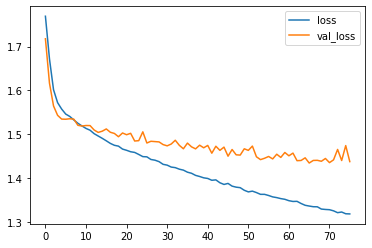

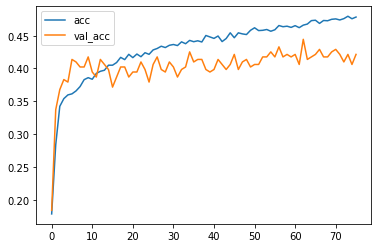

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)

test_acc = sum(y_pred == y_test) / len(y_test)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 43%


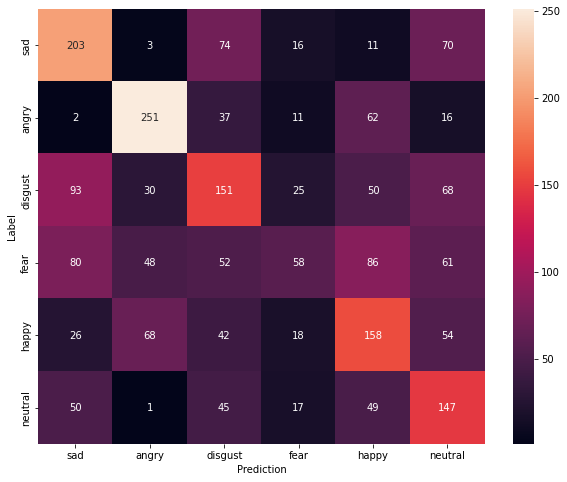

In [ ]:
classes = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
recall_1d = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis = 1)
precision_1d = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis = 0)

In [ ]:
print(recall_1d)
print(precision_1d)

[0.53846154 0.66226913 0.36211031 0.15064935 0.43169399 0.47572816]
[0.44713656 0.62593516 0.3765586  0.4        0.37980769 0.35336538]


In [ ]:
print(np.mean(recall_1d))
print(np.mean(precision_1d))
recall_1d.astype(np.int64)
precision_1d.astype(np.int64)
print(precision_1d)

0.4368187457599886
0.4304672343976273
[0.44713656 0.62593516 0.3765586  0.4        0.37980769 0.35336538]


In [ ]:
fscore = np.zeros(6)
for i in range(len(recall_1d)):
  fscore[i] = (2*precision_1d[i]*recall_1d[i])/(precision_1d[i]+recall_1d[i])
print(fscore)

[0.48856799 0.64358974 0.36919315 0.21886792 0.40409207 0.40551724]


Most confused classes are the ones with the lowest fscore --> Fear

AlexNet Model for 1D

In [ ]:
'''AlexNet_1D = Sequential()

#1st Convolutional Layer
AlexNet_1D.add(Conv1D(filters=96, kernel_size=2, strides=1, padding='same'))
AlexNet_1D.add(Activation('relu')) 
AlexNet_1D.add(BatchNormalization())

AlexNet_1D.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

#2nd Convolutional Layer
AlexNet_1D.add(Conv1D(filters=256, kernel_size=5, strides=1, padding='same'))
AlexNet_1D.add(Activation('relu')) 
AlexNet_1D.add(BatchNormalization())
AlexNet_1D.add(MaxPool1D(5, strides=2, padding='same'))

#3rd Convolutional Layer
AlexNet_1D.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same'))
AlexNet_1D.add(Activation('relu')) 
AlexNet_1D.add(BatchNormalization())

#4th Convolutional Layer
AlexNet_1D.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same'))
AlexNet_1D.add(Activation('relu')) 
AlexNet_1D.add(BatchNormalization())

#5th Convolutional Layer
AlexNet_1D.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same'))
AlexNet_1D.add(Activation('relu')) 
AlexNet_1D.add(BatchNormalization())
AlexNet_1D.add(MaxPool1D(5, strides=2, padding='same'))

#Passing it to a Fully Connected layer
AlexNet_1D.add(Flatten())
# 1st Fully Connected Layer
AlexNet_1D.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet_1D.add(Activation('relu')) 
AlexNet_1D.add(BatchNormalization())
# Add Dropout to prevent overfitting
AlexNet_1D.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet_1D.add(Dense(4096))
AlexNet_1D.add(Activation('relu')) 
AlexNet_1D.add(BatchNormalization())
#Add Dropout
AlexNet_1D.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet_1D.add(Dense(1000))
AlexNet_1D.add(Activation('relu')) 
AlexNet_1D.add(BatchNormalization())
#Add Dropout
AlexNet_1D.add(Dropout(0.4))

#Output Layer
AlexNet_1D.add(Dense(6))
AlexNet_1D.add(Activation('softmax'))
AlexNet_1D.add(BatchNormalization())'''

"AlexNet_1D = Sequential()\n\n#1st Convolutional Layer\nAlexNet_1D.add(Conv1D(filters=96, kernel_size=2, strides=1, padding='same'))\nAlexNet_1D.add(Activation('relu')) \nAlexNet_1D.add(BatchNormalization())\n\nAlexNet_1D.add(MaxPool1D(pool_size=2, strides=2, padding='same'))\n\n#2nd Convolutional Layer\nAlexNet_1D.add(Conv1D(filters=256, kernel_size=5, strides=1, padding='same'))\nAlexNet_1D.add(Activation('relu')) \nAlexNet_1D.add(BatchNormalization())\nAlexNet_1D.add(MaxPool1D(5, strides=2, padding='same'))\n\n#3rd Convolutional Layer\nAlexNet_1D.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same'))\nAlexNet_1D.add(Activation('relu')) \nAlexNet_1D.add(BatchNormalization())\n\n#4th Convolutional Layer\nAlexNet_1D.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same'))\nAlexNet_1D.add(Activation('relu')) \nAlexNet_1D.add(BatchNormalization())\n\n#5th Convolutional Layer\nAlexNet_1D.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same'))\nAlexNet_1D.a

In [ ]:
'''checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification2D.hdf5', verbose=1, save_best_only=True)
AlexNet_1D.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy() ,metrics='accuracy', optimizer='adam')'''

"checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification2D.hdf5', verbose=1, save_best_only=True)\nAlexNet_1D.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy() ,metrics='accuracy', optimizer='adam')"

In [ ]:
'''with tf.device('/device:GPU:0'):
  history = AlexNet_1D.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[es, checkpointer], verbose=1)'''

"with tf.device('/device:GPU:0'):\n  history = AlexNet_1D.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[es, checkpointer], verbose=1)"

In [ ]:
'''metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()'''

"metrics = history.history\nplt.plot(history.epoch, metrics['loss'], metrics['val_loss'])\nplt.legend(['loss', 'val_loss'])\nplt.show()\nplt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])\nplt.legend(['acc', 'val_acc'])\nplt.show()"

In [ ]:
'''y_pred = np.argmax(AlexNet_1D.predict(X_test), axis=1)

test_acc = sum(y_pred == y_test) / len(y_test)
print(f'Test set accuracy: {test_acc:.0%}')'''

"y_pred = np.argmax(AlexNet_1D.predict(X_test), axis=1)\n\ntest_acc = sum(y_pred == y_test) / len(y_test)\nprint(f'Test set accuracy: {test_acc:.0%}')"

In [ ]:
'''classes = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()'''

"classes = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']\nconfusion_mtx = tf.math.confusion_matrix(y_test, y_pred)\nplt.figure(figsize=(10, 8))\nsns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')\nplt.xlabel('Prediction')\nplt.ylabel('Label')\nplt.show()"

In [ ]:
def features_extractor2D(row):
  max_shape = (128, 157)
  sample, sr = librosa.load(row['Path'], sr=None)
  X = librosa.feature.melspectrogram(sample, sr=sr)
  padded_array = np.zeros(max_shape)
  shape = np.shape(X)
  padded_array[:shape[0],:shape[1]] = X
  X = padded_array
  X = np.expand_dims(X, axis=2)
  y = row['Emotion']
  return X, y


In [ ]:
def load_data2D(df, X, y):
  for index_num,row in tqdm(df.iterrows()):
      x, label =features_extractor2D(row)
      X.append(x)
      y.append(label)

In [ ]:
X_train2D = []
y_train2D = []
load_data2D(train_df, X_train2D, y_train2D)

0it [00:00, ?it/s]

In [ ]:
X_val2D = []
y_val2D = []
load_data2D(val_df, X_val2D, y_val2D)

0it [00:00, ?it/s]

In [ ]:
X_train2D = np.array(X_train2D)
y_train2D = np.array(y_train2D)
X_val2D = np.array(X_val2D)
y_val2D = np.array(y_val2D)
X_val2D.shape

(261, 128, 157, 1)

In [ ]:
X_test2D = []
y_test2D = []
load_data2D(test_df, X_test2D, y_test2D)
X_test2D = np.array(X_test2D)
y_test2D = np.array(y_test2D)

0it [00:00, ?it/s]

In [ ]:
model2D=Sequential()

model2D.add(Conv2D(256, 3, activation='relu'))
model2D.add(MaxPool2D(3, strides=2))

model2D.add(Conv2D(128, 3, activation='relu'))
model2D.add(MaxPool2D(3, strides=2, ))

model2D.add(Flatten())
model2D.add(Dense(128, activation='relu'))

model2D.add(Dense(6))
model2D.add(Activation('softmax'))

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification2D.hdf5', verbose=1, save_best_only=True)
model2D.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy() ,metrics='accuracy', optimizer='adam')

In [ ]:
with tf.device('/device:GPU:0'):
  history = model2D.fit(X_train2D, y_train2D, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val2D, y_val2D), callbacks=[checkpointer, es], verbose=1)

Epoch 1/2500
155/155 [==============================] - ETA: 0s - loss: 2.1155 - accuracy: 0.2508
Epoch 1: val_loss improved from inf to 1.73747, saving model to saved_models/audio_classification2D.hdf5
155/155 [==============================] - 34s 207ms/step - loss: 2.1155 - accuracy: 0.2508 - val_loss: 1.7375 - val_accuracy: 0.2644
Epoch 2/2500
155/155 [==============================] - ETA: 0s - loss: 1.6866 - accuracy: 0.3159
Epoch 2: val_loss did not improve from 1.73747
155/155 [==============================] - 30s 196ms/step - loss: 1.6866 - accuracy: 0.3159 - val_loss: 1.7569 - val_accuracy: 0.2797
Epoch 3/2500
155/155 [==============================] - ETA: 0s - loss: 1.5853 - accuracy: 0.3541
Epoch 3: val_loss improved from 1.73747 to 1.71658, saving model to saved_models/audio_classification2D.hdf5
155/155 [==============================] - 31s 200ms/step - loss: 1.5853 - accuracy: 0.3541 - val_loss: 1.7166 - val_accuracy: 0.3870
Epoch 4/2500
155/155 [=====================

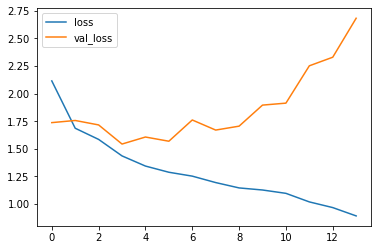

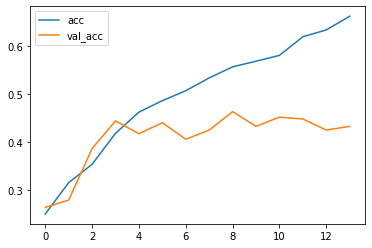

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()

In [ ]:
y_pred_2D = np.argmax(model2D.predict(X_test2D), axis=1)

test_acc = sum(y_pred_2D == y_test2D) / len(y_test2D)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 43%


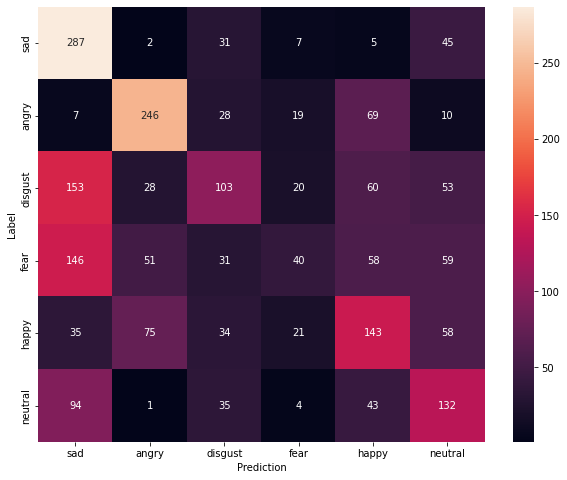

In [ ]:
classes = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']
confusion_mtx_2d = tf.math.confusion_matrix(y_test2D, y_pred_2D)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_2d, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
recall_2d = np.diag(confusion_mtx_2d) / np.sum(confusion_mtx_2d, axis = 1)
precision_2d = np.diag(confusion_mtx_2d) / np.sum(confusion_mtx_2d, axis = 0)

In [ ]:
print (recall_2d)
print(precision_2d)


[0.76127321 0.64907652 0.2470024  0.1038961  0.39071038 0.42718447]
[0.39750693 0.61042184 0.39312977 0.36036036 0.37830688 0.3697479 ]


In [ ]:
fscore = np.zeros(6)
for i in range(len(recall_2d)):
   fscore[i] = (2*precision_2d[i]*recall_2d[i])/(precision_2d[i]+recall_2d[i])
print(fscore)  


[0.52229299 0.62915601 0.30338733 0.16129032 0.3844086  0.3963964 ]


Again: Fear and disgust

In [ ]:
print(np.mean(recall_2d))
print(np.mean(precision_2d))

0.4298571795350308
0.4182456117092188


Trying Alexnet model

In [ ]:
from keras.layers import BatchNormalization

In [ ]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(128,157,1), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(6))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
#AlexNet.summary()

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification2D.hdf5', verbose=1, save_best_only=True)
AlexNet.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy() ,metrics='accuracy', optimizer='adam')

In [ ]:
with tf.device('/device:GPU:0'):
  history = AlexNet.fit(X_train2D, y_train2D, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val2D, y_val2D), callbacks=[checkpointer, es], verbose=1)

Epoch 1/2500
155/155 [==============================] - ETA: 0s - loss: 1.6128 - accuracy: 0.3422
Epoch 1: val_loss improved from inf to 1.82473, saving model to saved_models/audio_classification2D.hdf5
155/155 [==============================] - 16s 83ms/step - loss: 1.6128 - accuracy: 0.3422 - val_loss: 1.8247 - val_accuracy: 0.2375
Epoch 2/2500
155/155 [==============================] - ETA: 0s - loss: 1.5241 - accuracy: 0.3892
Epoch 2: val_loss did not improve from 1.82473
155/155 [==============================] - 10s 63ms/step - loss: 1.5241 - accuracy: 0.3892 - val_loss: 2.0586 - val_accuracy: 0.2031
Epoch 3/2500
155/155 [==============================] - ETA: 0s - loss: 1.4749 - accuracy: 0.4060
Epoch 3: val_loss improved from 1.82473 to 1.79783, saving model to saved_models/audio_classification2D.hdf5
155/155 [==============================] - 12s 77ms/step - loss: 1.4749 - accuracy: 0.4060 - val_loss: 1.7978 - val_accuracy: 0.2529
Epoch 4/2500
155/155 [========================

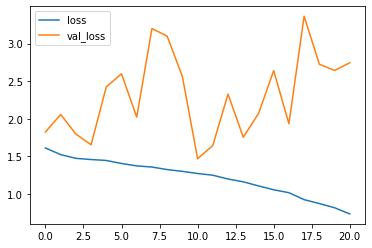

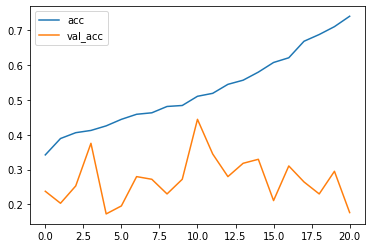

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()

In [ ]:
y_pred_AlexNet = np.argmax(AlexNet.predict(X_test2D), axis=1)

test_acc = sum(y_pred_AlexNet == y_test2D) / len(y_test2D)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 42%


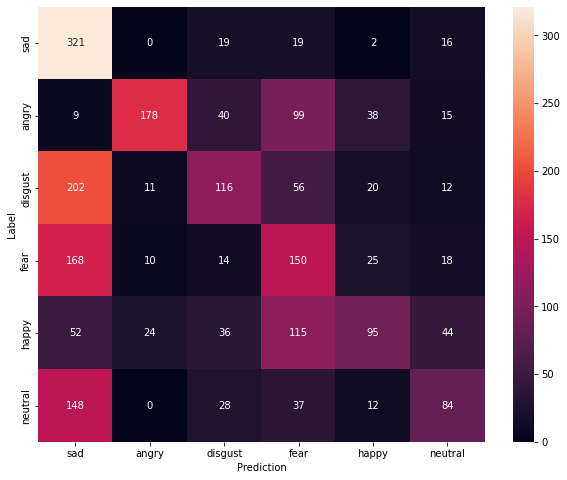

In [ ]:
classes = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']
confusion_mtx_2d = tf.math.confusion_matrix(y_test2D, y_pred_AlexNet)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_2d, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
recall_2d = np.diag(confusion_mtx_2d) / np.sum(confusion_mtx_2d, axis = 1)
precision_2d = np.diag(confusion_mtx_2d) / np.sum(confusion_mtx_2d, axis = 0)

In [ ]:
print (recall_2d)
print(precision_2d)


[0.85145889 0.46965699 0.27817746 0.38961039 0.25956284 0.27184466]
[0.35666667 0.79820628 0.45849802 0.31512605 0.49479167 0.44444444]


In [ ]:
print(np.mean(recall_2d))
print(np.mean(precision_2d))

0.42005187123237825
0.4779555216567111


In [ ]:
fscore = np.zeros(6)
for i in range(len(recall_2d)):
   fscore[i] = (2*precision_2d[i]*recall_2d[i])/(precision_2d[i]+recall_2d[i])
print(fscore)  


[0.5027408  0.59136213 0.34626866 0.34843206 0.34050179 0.3373494 ]


In [ ]:
print(f"Fscore for AlexNet2D: {np.mean(fscore)}")

Fscore for AlexNet2D: 0.4111091378605858


# 4. Big Picture

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

For Keras Models

In [ ]:
precision_1d = precision_score(y_test, y_pred, average='weighted')
print('Precision for 1D: %.3f' % precision_1d)

Precision for 1D: 0.432


In [ ]:
precision_2d = precision_score(y_test2D, y_pred_2D, average='weighted')
print('Precision for 2D: %.3f' % precision_2d)

Precision for 2D: 0.419


In [ ]:
recall_1d = recall_score(y_test, y_pred, average='weighted')
print('Recall for 1D: %.3f' % recall_1d)

Recall for 1D: 0.433


In [ ]:
recall_2d = recall_score(y_test2D, y_pred_2D, average='weighted')
print('Recall for 2D: %.3f' % recall_2d)

Recall for 2D: 0.426


In [ ]:
f1score_1d = f1_score(y_test, y_pred, average = 'weighted')
print('F1 score for 1D: %f' % f1score_1d)

F1 score for 1D: 0.420748


In [ ]:
f1score_2d = f1_score(y_test2D, y_pred_2D, average = 'weighted')
print('F1 score for 2D: %f' % f1score_2d)

F1 score for 2D: 0.397288
